In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from datetime import datetime

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets
data = transactions.merge(customers, on="CustomerID", how="left")

# Preview the merged data
print("Data Preview:")
display(data.head())

# Check for missing values
print("\nMissing Values Summary:")
print(data.isnull().sum())


Data Preview:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15



Missing Values Summary:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
CustomerName       0
Region             0
SignupDate         0
dtype: int64


In [7]:
data.fillna(0, inplace=True)

# Convert TransactionDate to datetime
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

# Add a column for the month of purchase
data["TransactionMonth"] = data["TransactionDate"].dt.month

In [8]:
customer_profiles = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    total_quantity=("Quantity", "sum"),
    transaction_count=("TransactionID", "nunique"),
    product_diversity=("ProductID", "nunique"),
    first_purchase=("TransactionDate", "min"),
    last_purchase=("TransactionDate", "max")
).reset_index()

# Add RFM (Recency, Frequency, Monetary) metrics
customer_profiles["recency_days"] = (datetime.now() - customer_profiles["last_purchase"]).dt.days
customer_profiles["frequency"] = customer_profiles["transaction_count"]
customer_profiles["monetary_value"] = customer_profiles["total_spent"]


In [9]:
# Add Customer Lifetime Value (CLTV)
customer_profiles["cltv"] = (
    customer_profiles["monetary_value"] * customer_profiles["frequency"] / customer_profiles["recency_days"]
)

# Add churn risk: High recency implies high churn risk
customer_profiles["churn_risk"] = customer_profiles["recency_days"].apply(lambda x: 1 if x > 365 else 0)

In [10]:
# Analyze monthly spending patterns
monthly_spending = data.groupby(["CustomerID", "TransactionMonth"]).agg(
    total_monthly_spend=("TotalValue", "sum")
).reset_index()

# Pivot monthly spending for each customer
monthly_spending_pivot = monthly_spending.pivot(index="CustomerID", columns="TransactionMonth", values="total_monthly_spend").fillna(0)

# Merge monthly spending with customer profiles
customer_profiles = customer_profiles.merge(monthly_spending_pivot, on="CustomerID", how="left").fillna(0)

# Preview updated customer profiles
print("Enhanced Customer Profiles with Advanced Features:")
display(customer_profiles.head())

Enhanced Customer Profiles with Advanced Features:


,CustomerID,total_spent,avg_transaction_value,total_quantity,transaction_count,product_diversity,first_purchase,last_purchase,recency_days,frequency,...,3,4,5,6,7,8,9,10,11,12
0,C0001,3354.52,670.904,12,5,5,2024-01-19 03:12:55,2024-11-02 17:04:16,86,5,...,0.00,614.94,911.44,0.00,0.00,0.00,412.62,0.00,1300.92,0.00
1,C0002,1862.74,465.685,10,4,4,2024-02-28 07:44:21,2024-12-03 01:41:41,55,4,...,0.00,0.00,0.00,382.76,454.52,0.00,0.00,0.00,0.00,254.72
2,C0003,2725.38,681.345,14,4,4,2024-02-18 02:50:37,2024-08-24 18:54:04,156,4,...,0.00,0.00,0.00,1217.82,0.00,1385.20,0.00,0.00,0.00,0.00
3,C0004,5354.88,669.360,23,8,8,2024-02-28 10:16:35,2024-12-23 14:13:52,35,8,...,1099.76,0.00,0.00,958.02,591.80,441.66,0.00,338.66,0.00,1631.28
4,C0005,2034.24,678.080,7,3,3,2024-03-15 04:08:59,2024-11-04 00:30:22,84,3,...,861.18,0.00,853.86,0.00,0.00,0.00,0.00,0.00,319.20,0.00


In [11]:
# Define numerical features for scaling
numerical_features = ["total_spent", "avg_transaction_value", "total_quantity", "transaction_count",
                      "product_diversity", "recency_days", "cltv"]

# Scale features using RobustScaler (handles outliers effectively)
scaler = RobustScaler()
scaled_features = scaler.fit_transform(customer_profiles[numerical_features])

# Combine scaled features with monthly spending
final_features = np.hstack([scaled_features, customer_profiles.filter(like="TransactionMonth").values])

# Check the shape of final features
print("Shape of Final Features:", final_features.shape)

Shape of Final Features: (199, 7)


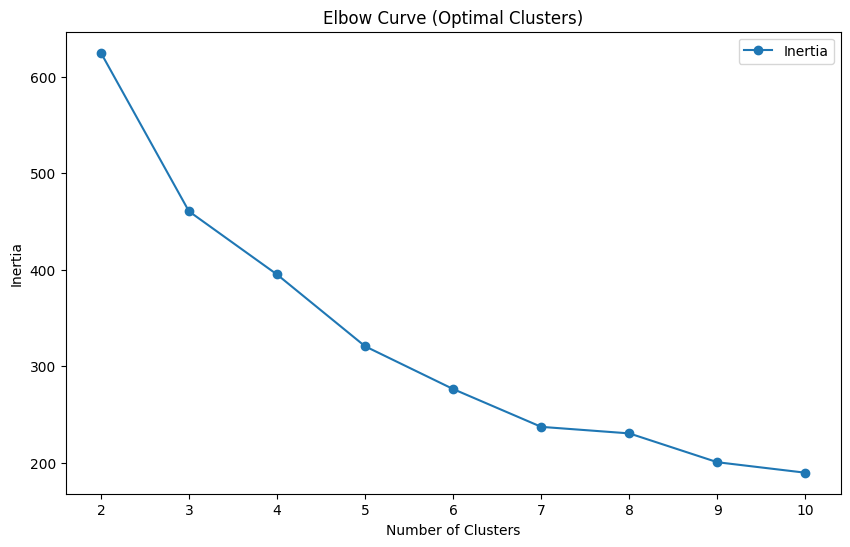

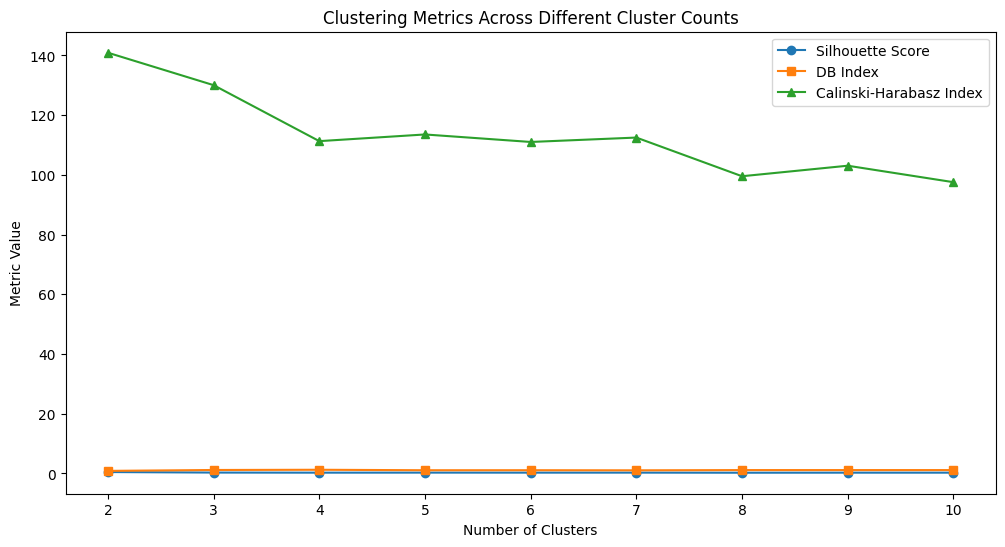

In [32]:
# Evaluate optimal number of clusters using K-Means
inertia = []
silhouette_scores = []
db_indices = []
ch_indices = []  # Calinski-Harabasz Index
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans.labels_))
    db_indices.append(davies_bouldin_score(final_features, kmeans.labels_))
    ch_indices.append(calinski_harabasz_score(final_features, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker="o", label="Inertia")
plt.title("Elbow Curve (Optimal Clusters)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.legend()
plt.show()

# Plot Silhouette, DB Index, and Calinski-Harabasz Index
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker="o", label="Silhouette Score")
plt.plot(cluster_range, db_indices, marker="s", label="DB Index")
plt.plot(cluster_range, ch_indices, marker="^", label="Calinski-Harabasz Index")
plt.title("Clustering Metrics Across Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

In [41]:
cluster_summary = customer_profiles.groupby("Cluster").agg(
    avg_spent=("total_spent", "mean"),
    avg_recency=("recency_days", "mean"),
    avg_cltv=("cltv", "mean"),
    churn_risk=("churn_risk", "mean"),
    cluster_size=("CustomerID", "count")
).reset_index()
optimal_clusters = 5  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(final_features)

# Calculate final evaluation metrics
silhouette = silhouette_score(final_features, customer_profiles["Cluster"])
db_index = davies_bouldin_score(final_features, customer_profiles["Cluster"])
ch_index = calinski_harabasz_score(final_features, customer_profiles["Cluster"])

print(f"Final Evaluation Metrics:")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies-Bouldin Index: {db_index:.4f}")
print(f"  Calinski-Harabasz Index: {ch_index:.4f}")

Final Evaluation Metrics:
  Silhouette Score: 0.2710
  Davies-Bouldin Index: 1.0703
  Calinski-Harabasz Index: 113.5291


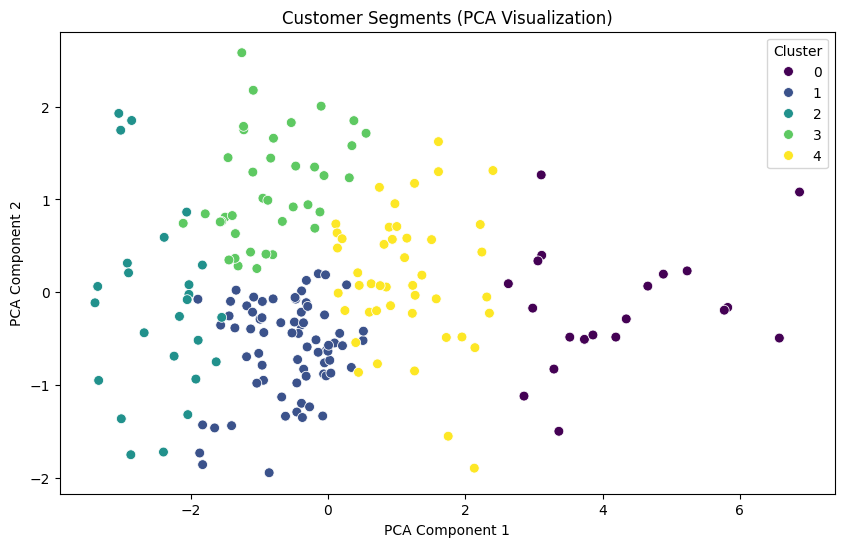

In [42]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_features)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=customer_profiles["Cluster"],
    palette="viridis",
    s=50
)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

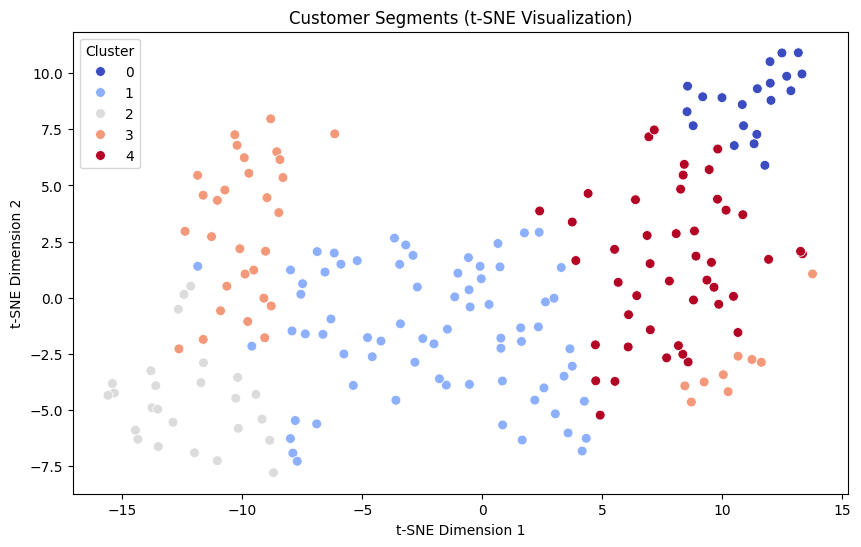

In [43]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(final_features)

# Scatter plot with t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=tsne_features[:, 0],
    y=tsne_features[:, 1],
    hue=customer_profiles["Cluster"],
    palette="coolwarm",
    s=50
)
plt.title("Customer Segments (t-SNE Visualization)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()

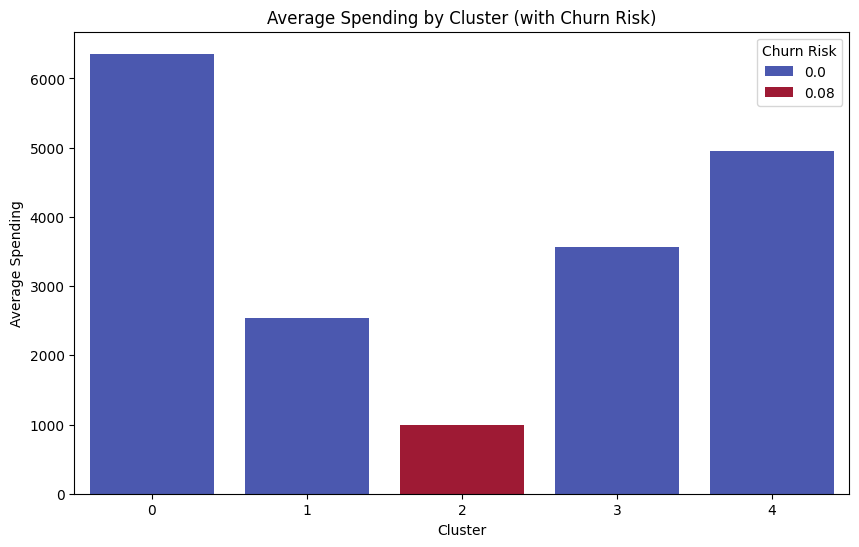

In [44]:
# Summarize each cluster with business insights
cluster_summary = customer_profiles.groupby("Cluster").agg(
    avg_spent=("total_spent", "mean"),
    avg_recency=("recency_days", "mean"),
    avg_cltv=("cltv", "mean"),
    churn_risk=("churn_risk", "mean"),
    cluster_size=("CustomerID", "count")
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary, 
    x="Cluster", 
    y="avg_spent", 
    hue="churn_risk",  
    palette="coolwarm"
)
plt.title("Average Spending by Cluster (with Churn Risk)")
plt.xlabel("Cluster")
plt.ylabel("Average Spending")
plt.legend(title="Churn Risk")
plt.show()

In [45]:
cluster_summary = customer_profiles.groupby("Cluster").agg(
    avg_spent=("total_spent", "mean"),
    avg_recency=("recency_days", "mean"),
    avg_cltv=("cltv", "mean"),
    churn_risk=("churn_risk", "mean"),
    cluster_size=("CustomerID", "count")
).reset_index()

In [46]:
# Display cluster profiles
print("Cluster Profiles:")
display(cluster_summary)


Cluster Profiles:


,Cluster,avg_spent,avg_recency,avg_cltv,churn_risk,cluster_size
0,0,6357.031500,43.450000,1318.871987,0.00,20
1,1,2532.069014,77.704225,187.184595,0.00,71
2,2,997.033600,218.840000,14.119534,0.08,25
3,3,3559.829737,130.842105,122.418501,0.00,38
4,4,4952.859111,87.777778,448.423444,0.00,45
